In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.nyt_connections import get_connections_games, get_connections_tasks
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.tokenize import TaskResultTokenizer
from lib.tune import get_iteration, last_tune_log, tune
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "011"
wandb.init(
    project="grpo-tests",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "nyt-connections"},
)

games = get_connections_games()
tasks = list(
    islice(get_connections_tasks(games, parse_answers_liberally=False), len(games) * 2)
)
distill_tasks = tasks[:436]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
random.seed(42)
random.shuffle(train_tasks)
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(436, 72, 92, 436)

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

$ vllm serve deepseek-ai/DeepSeek-R1-Distill-Qwen-7B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --port=8000 --api-key=default
INFO 02-19 14:16:34 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 14:16:36 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 14:16:36 api_server.py:841] args: Namespace(subparser='serve', model_tag='deepseek-ai/DeepSeek-R1-Distill-Qwen-7B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=N

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:02<00:02,  2.23s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:05<00:00,  2.71s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:05<00:00,  2.64s/it]



INFO 02-19 14:17:24 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 14:17:26 worker.py:267] Memory profiling takes 1.39 seconds
INFO 02-19 14:17:26 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 14:17:26 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 14:17:26 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 14:17:26 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 14:18:13 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.91 seconds
INFO 02-19 14:18:14 api_server.py:756] Using supplied chat template:
INFO 02-19 14:18:14 api_server.py:756] None
INFO 02-19 14:18:14 launcher.py:21] Available routes are:
INFO 02-19 14:18:14 launcher.py:29] Route: /

INFO:     Started server process [6950]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 14:18:19 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:36720 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/256 [00:00<?, ?it/s]

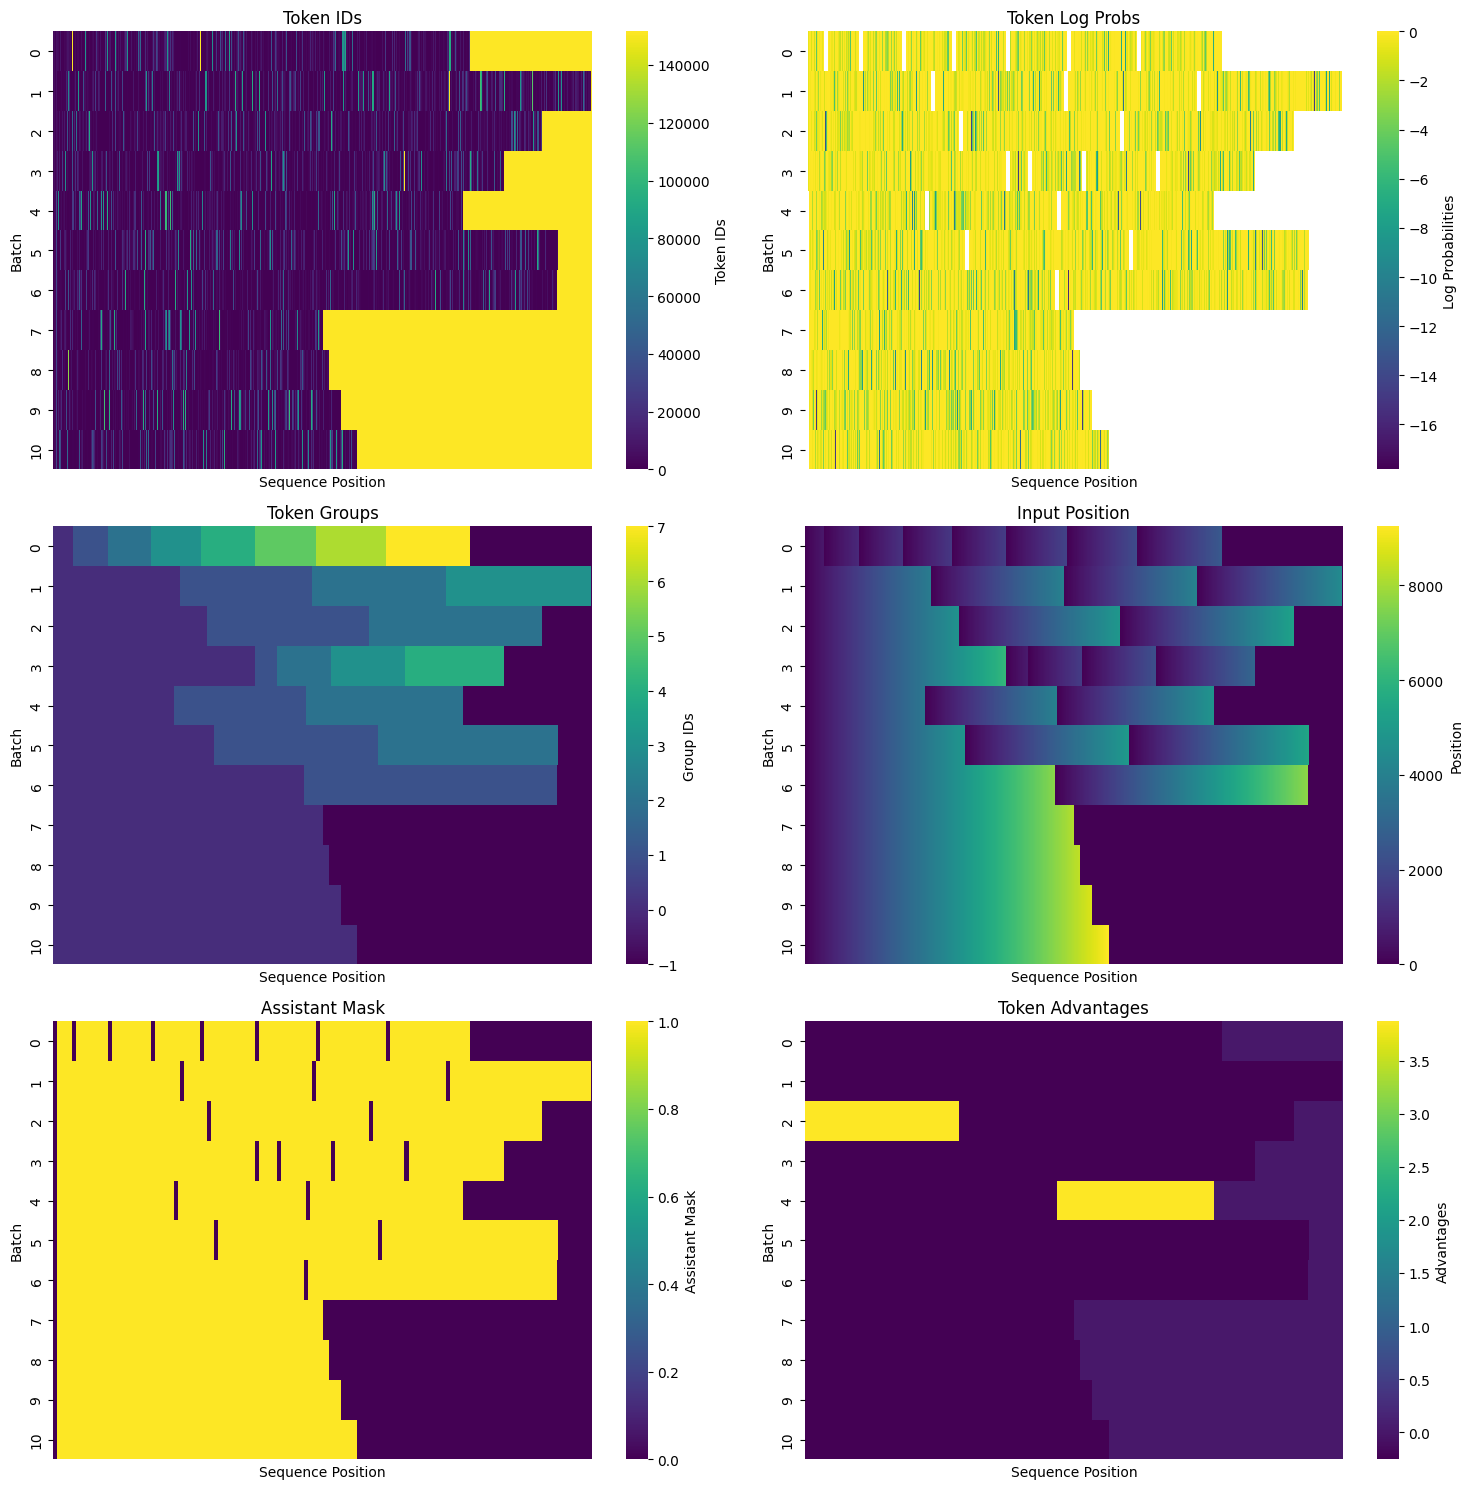

Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/blobs/a6344aac8c09253b3b630fb776ae94478aa0275b
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/blobs/d42fae903e9fa07f3e8edb0db00a8d905ba49560
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/blobs/d6ff9c6d4933688f95f315e3ce08f8e5e28eaeee
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/blobs/d1fd67ec1bf748c24b244b6efd825ded1b147787
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/011/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/011
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/011/tensors
  num_seque

Writing logs to models/011/logs/log_1739975153.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 29.72 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: 0.2365: 100%|██████████| 5/5 [02:29<00:00, 28.62s/it, entropy=3.32, kl_div=0.568, loss=0.236, policy=0.236]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.25 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved to mod

Saved iteration 1 model files to ./models/011/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/011/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/011/0001 --port=8000 --api-key=default
INFO 02-19 14:29:29 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 14:29:30 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 14:29:30 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/011/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.16s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.45s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.56s/it]



INFO 02-19 14:29:52 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 14:29:53 worker.py:267] Memory profiling takes 0.81 seconds
INFO 02-19 14:29:53 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 14:29:53 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 14:29:53 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 14:29:53 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 14:30:30 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 38.20 seconds
INFO 02-19 14:30:31 api_server.py:756] Using supplied chat template:
INFO 02-19 14:30:31 api_server.py:756] None
INFO 02-19 14:30:31 launcher.py:21] Available routes are:
INFO 02-19 14:30:31 launcher.py:29] Route: /

INFO:     Started server process [8144]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 14:30:33 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:37664 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a420fdee980>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/256 [00:00<?, ?it/s]

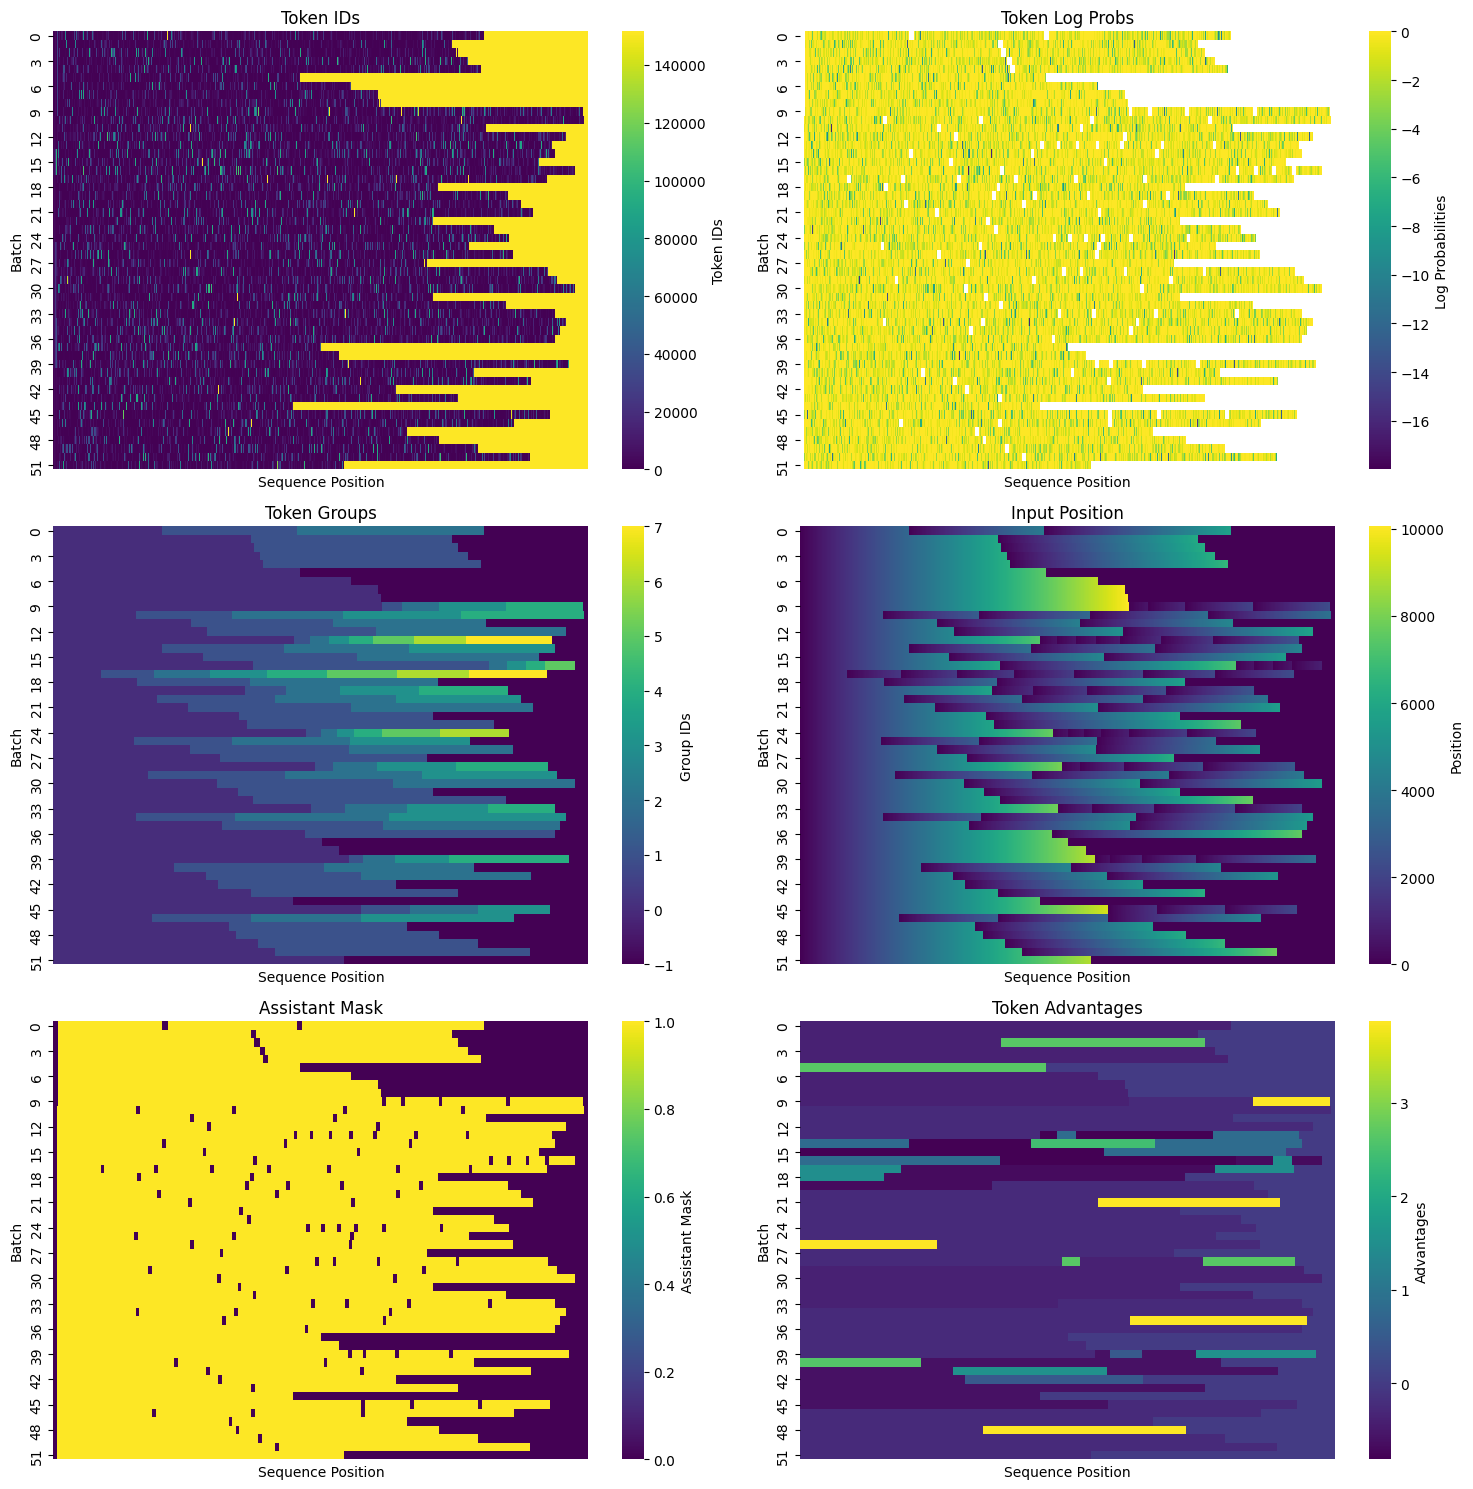

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/011/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/011
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/011/tensors
  num_seque

Writing logs to models/011/logs/log_1739975907.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 30.77 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|26|Loss: 0.1911: 100%|██████████| 26/26 [12:14<00:00, 27.85s/it, entropy=2.65, kl_div=0.504, loss=0.191, policy=0.191]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.21 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB save

Saved iteration 1 model files to ./models/011/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/011/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/011/0001 --port=8000 --api-key=default
INFO 02-19 14:51:49 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 14:51:50 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 14:51:50 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/011/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.72s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.68s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.83s/it]



INFO 02-19 14:52:15 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 14:52:16 worker.py:267] Memory profiling takes 0.87 seconds
INFO 02-19 14:52:16 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 14:52:16 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 14:52:16 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 14:52:16 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 14:52:53 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 37.86 seconds
INFO 02-19 14:52:54 api_server.py:756] Using supplied chat template:
INFO 02-19 14:52:54 api_server.py:756] None
INFO 02-19 14:52:54 launcher.py:21] Available routes are:
INFO 02-19 14:52:54 launcher.py:29] Route: /

INFO:     Started server process [9054]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 14:52:55 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:33372 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a420fdee980>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/256 [00:00<?, ?it/s]

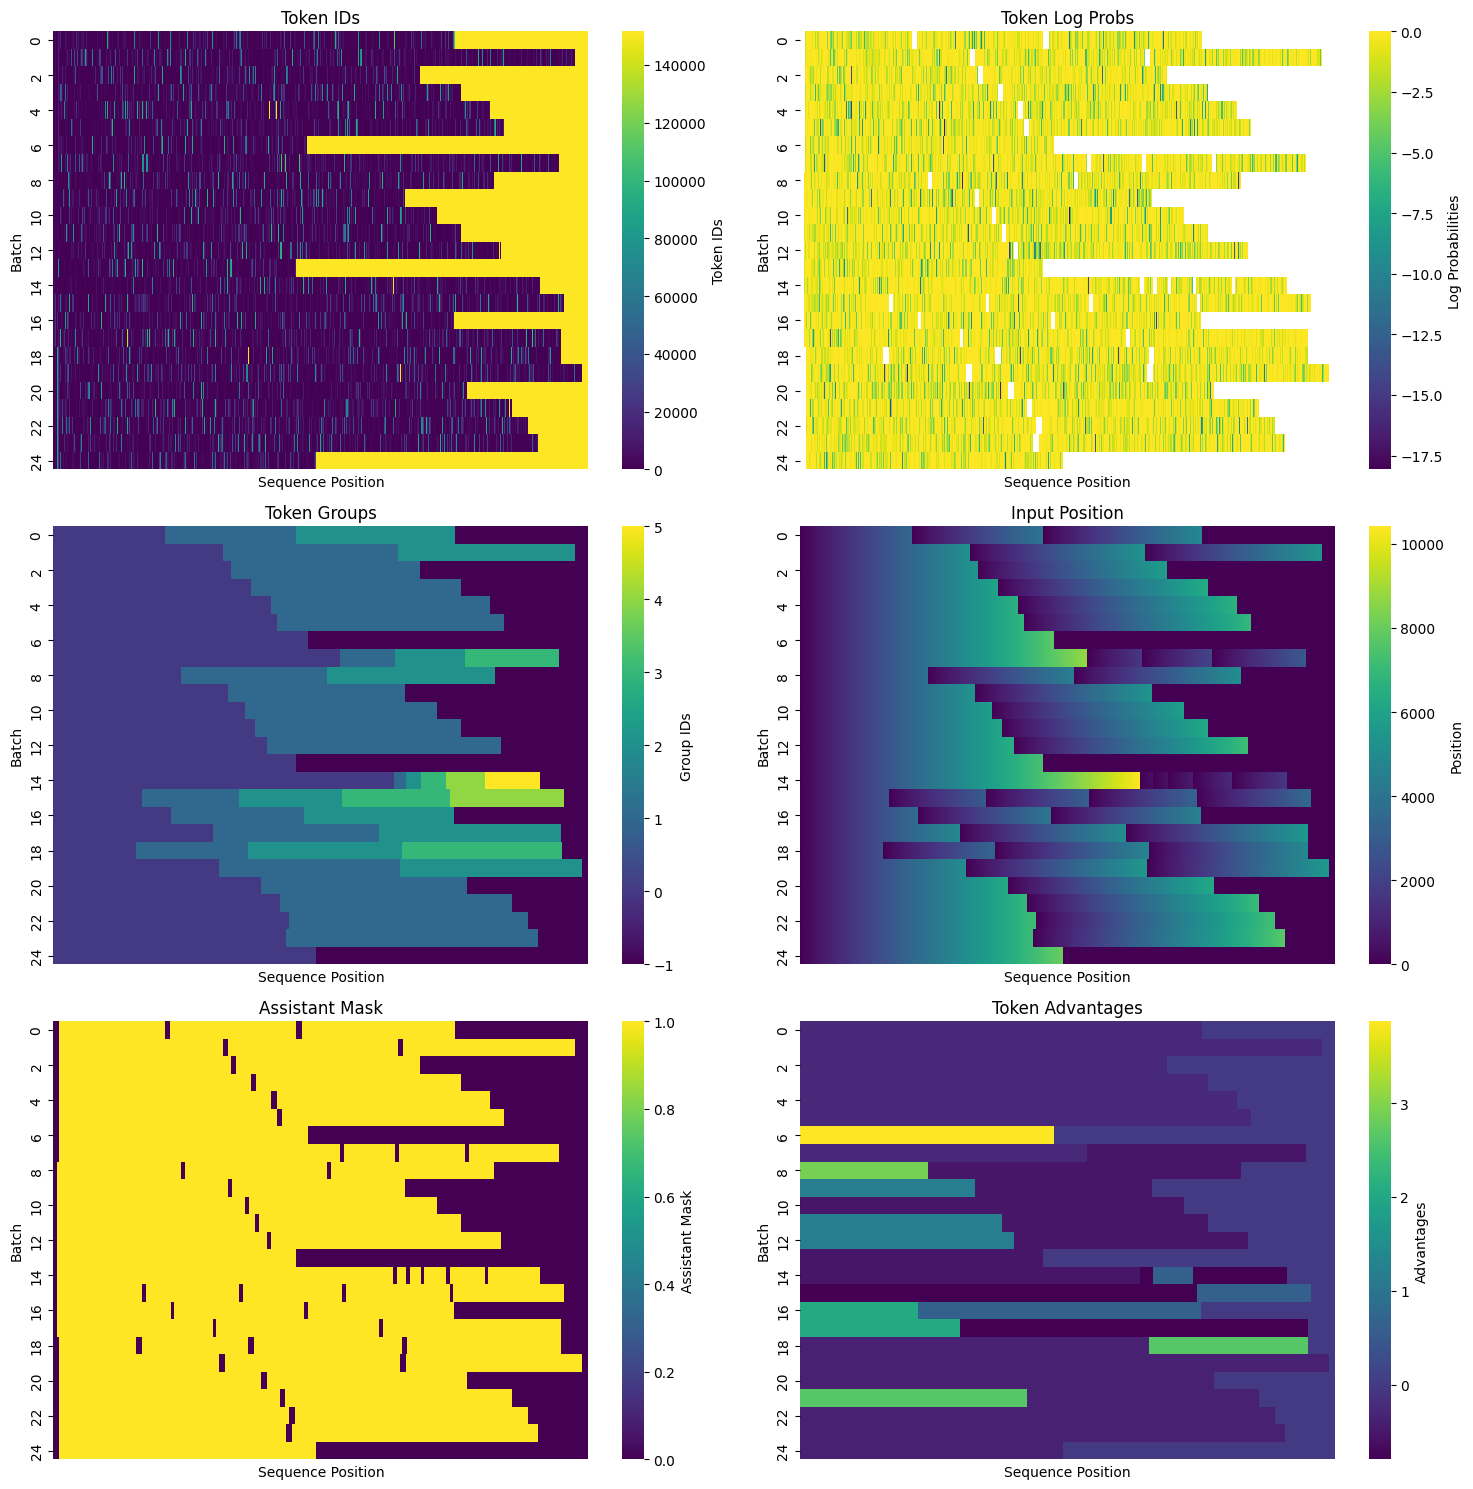

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/011/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/011
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/011/tensors
  num_seque

Writing logs to models/011/logs/log_1739977240.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 33.32 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|12|Loss: 0.2843: 100%|██████████| 12/12 [05:45<00:00, 28.00s/it, entropy=2.83, kl_div=0.514, loss=0.284, policy=0.284]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.49 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved t

Saved iteration 1 model files to ./models/011/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/011/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/011/0001 --port=8000 --api-key=default
INFO 02-19 15:07:36 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 15:07:37 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 15:07:37 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/011/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.16s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.46s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.56s/it]



INFO 02-19 15:07:58 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 15:07:59 worker.py:267] Memory profiling takes 0.80 seconds
INFO 02-19 15:07:59 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 15:07:59 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 15:07:59 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 15:07:59 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 15:08:37 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 38.70 seconds
INFO 02-19 15:08:38 api_server.py:756] Using supplied chat template:
INFO 02-19 15:08:38 api_server.py:756] None
INFO 02-19 15:08:38 launcher.py:21] Available routes are:
INFO 02-19 15:08:38 launcher.py:29] Route: /

INFO:     Started server process [9646]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 15:08:38 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:55020 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a420fdee980>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/256 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (16386 > 16384). Running this sequence through the model will result in indexing errors


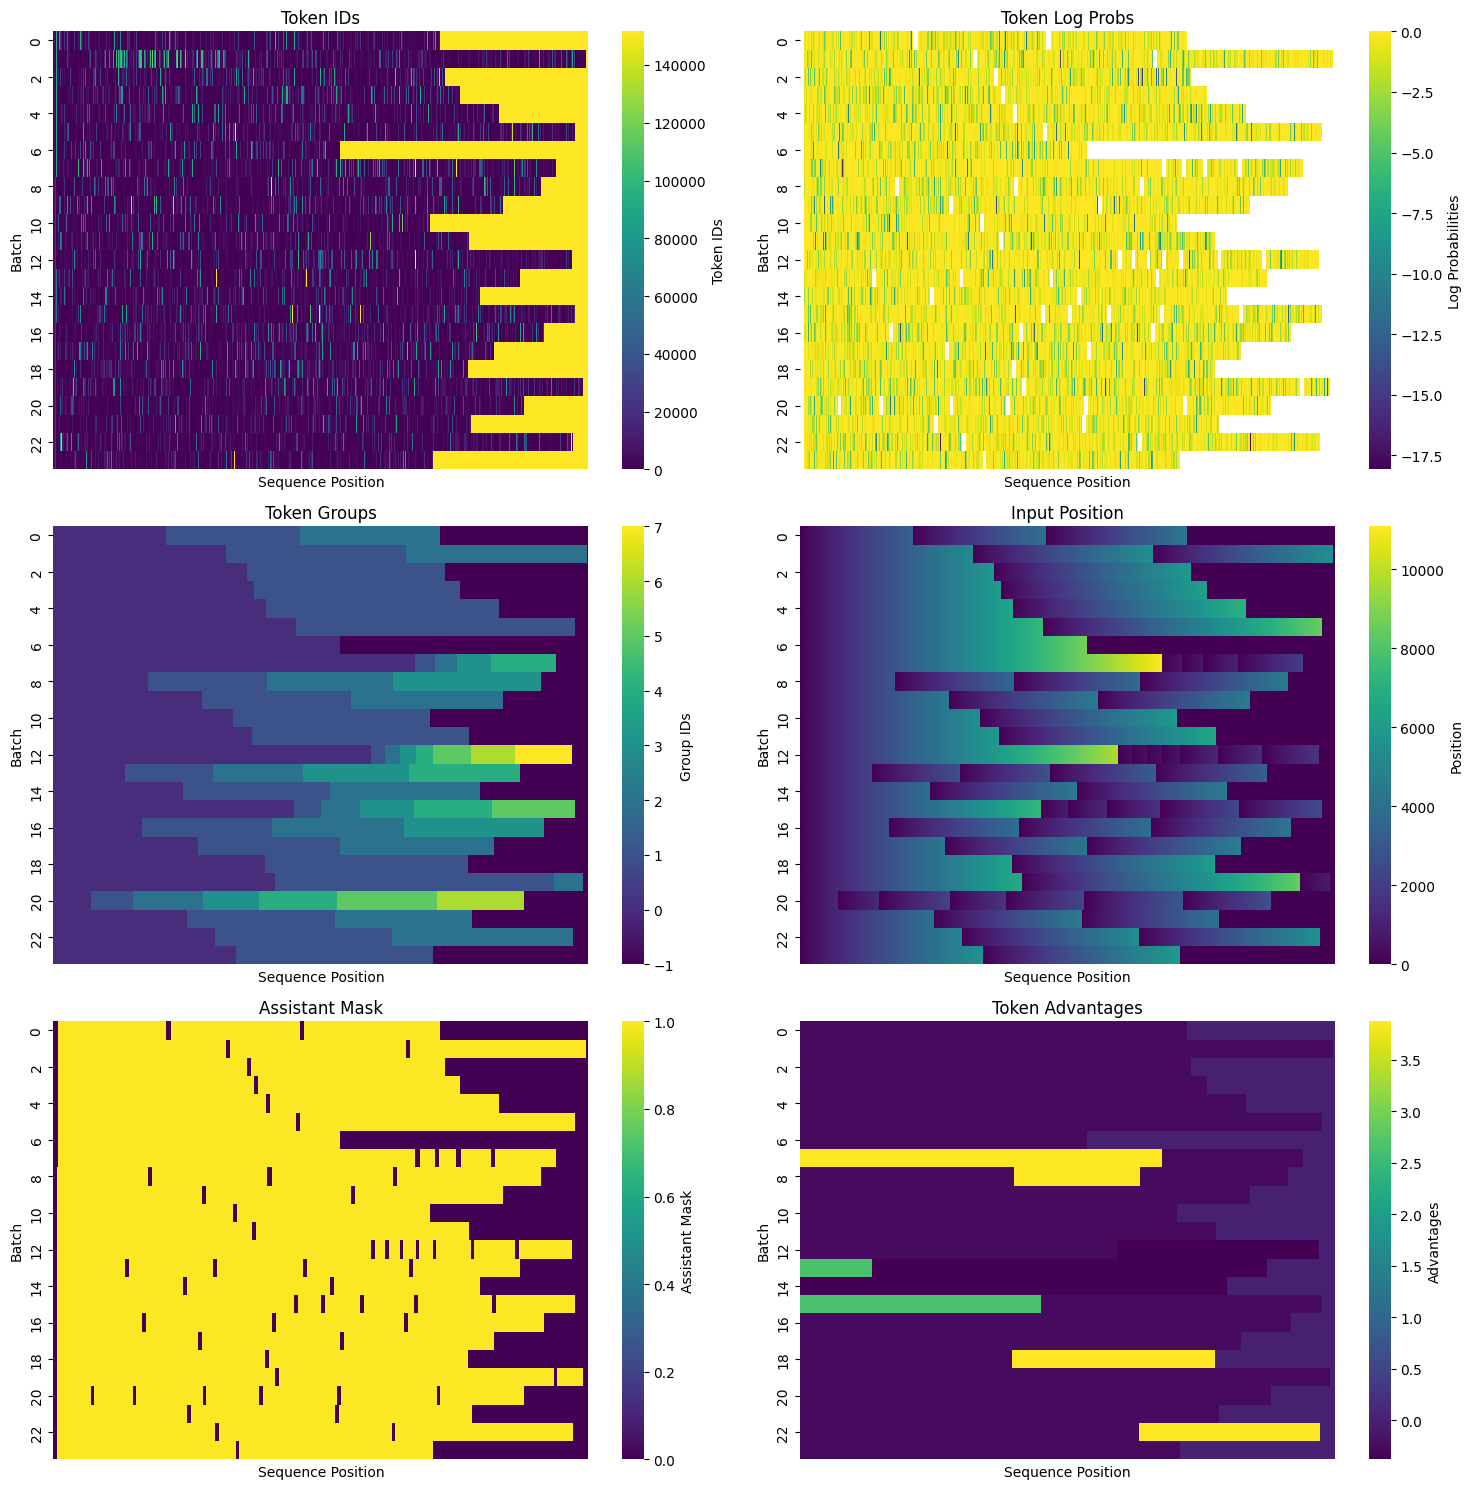

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/011/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/011
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/011/tensors
  num_seque

Writing logs to models/011/logs/log_1739978203.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.92 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|12|Loss: -5.9504: 100%|██████████| 12/12 [05:44<00:00, 27.89s/it, entropy=2.25, kl_div=0.497, loss=-5.95, policy=-5.95]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.37 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved to

Saved iteration 1 model files to ./models/011/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/011/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/011/0001 --port=8000 --api-key=default
INFO 02-19 15:23:39 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 15:23:41 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 15:23:41 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/011/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:07<00:07,  7.29s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:11<00:00,  5.34s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:11<00:00,  5.63s/it]



INFO 02-19 15:24:08 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 15:24:08 worker.py:267] Memory profiling takes 0.80 seconds
INFO 02-19 15:24:08 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 15:24:08 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 15:24:09 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 15:24:09 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 15:24:50 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 42.50 seconds
INFO 02-19 15:24:51 api_server.py:756] Using supplied chat template:
INFO 02-19 15:24:51 api_server.py:756] None
INFO 02-19 15:24:51 launcher.py:21] Available routes are:
INFO 02-19 15:24:51 launcher.py:29] Route: /

INFO:     Started server process [10362]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 15:24:57 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-19 15:24:57 metrics.py:455] Avg prompt throughput: 1.1 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-19 15:24:57 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:54586 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a420fdee980>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/256 [00:00<?, ?it/s]

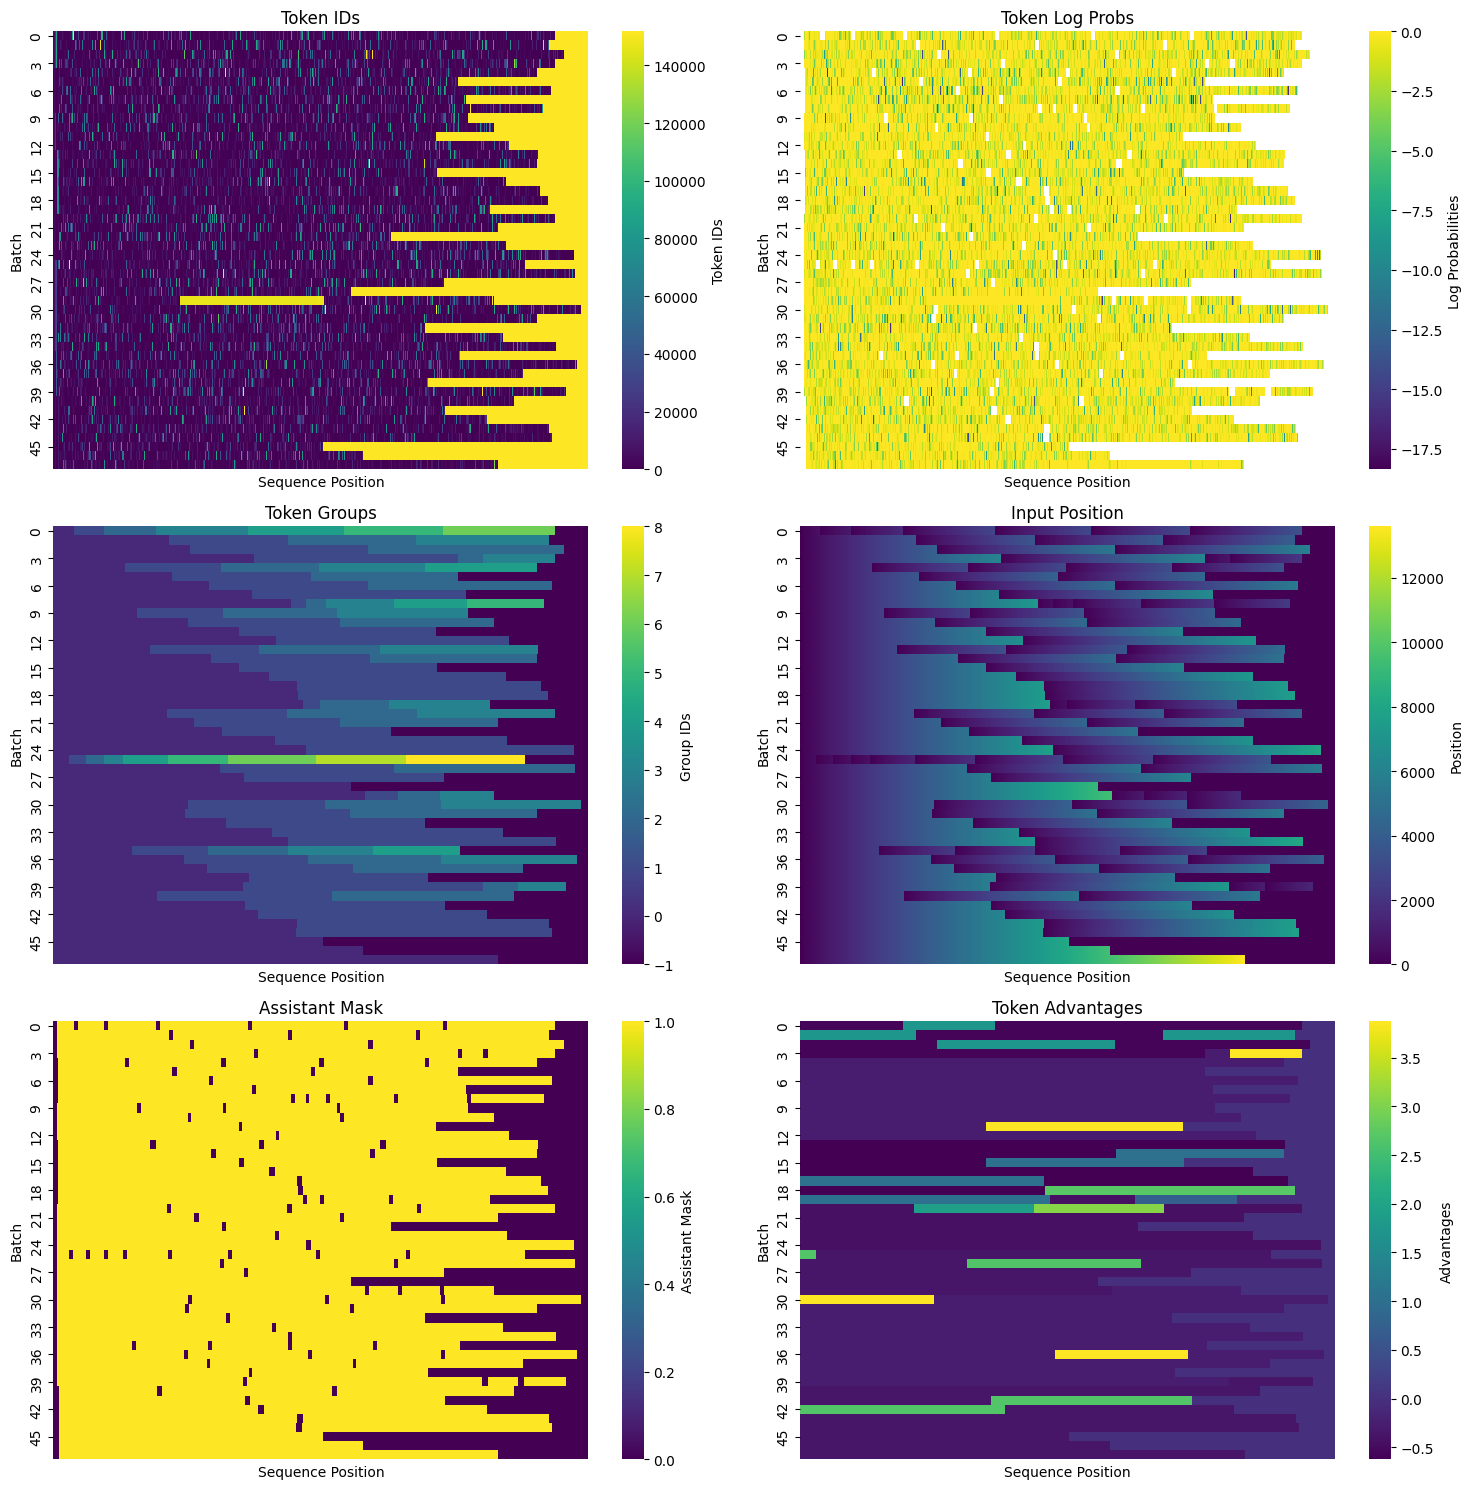

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/011/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/011
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/011/tensors
  num_seque

Writing logs to models/011/logs/log_1739979135.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 30.11 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|24|Loss: 0.4722: 100%|██████████| 24/24 [11:20<00:00, 27.74s/it, entropy=2.34, kl_div=0.479, loss=0.472, policy=0.472]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 8.54 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved 

Saved iteration 1 model files to ./models/011/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/011/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/011/0001 --port=8000 --api-key=default
INFO 02-19 15:44:43 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 15:44:44 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 15:44:44 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/011/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.16s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.47s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.58s/it]



INFO 02-19 15:45:07 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 15:45:08 worker.py:267] Memory profiling takes 0.87 seconds
INFO 02-19 15:45:08 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 15:45:08 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 15:45:09 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 15:45:09 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 15:45:47 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 39.36 seconds
INFO 02-19 15:45:49 api_server.py:756] Using supplied chat template:
INFO 02-19 15:45:49 api_server.py:756] None
INFO 02-19 15:45:49 launcher.py:21] Available routes are:
INFO 02-19 15:45:49 launcher.py:29] Route: /

INFO:     Started server process [11410]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 15:45:53 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:35270 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a420fdee980>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/256 [00:00<?, ?it/s]

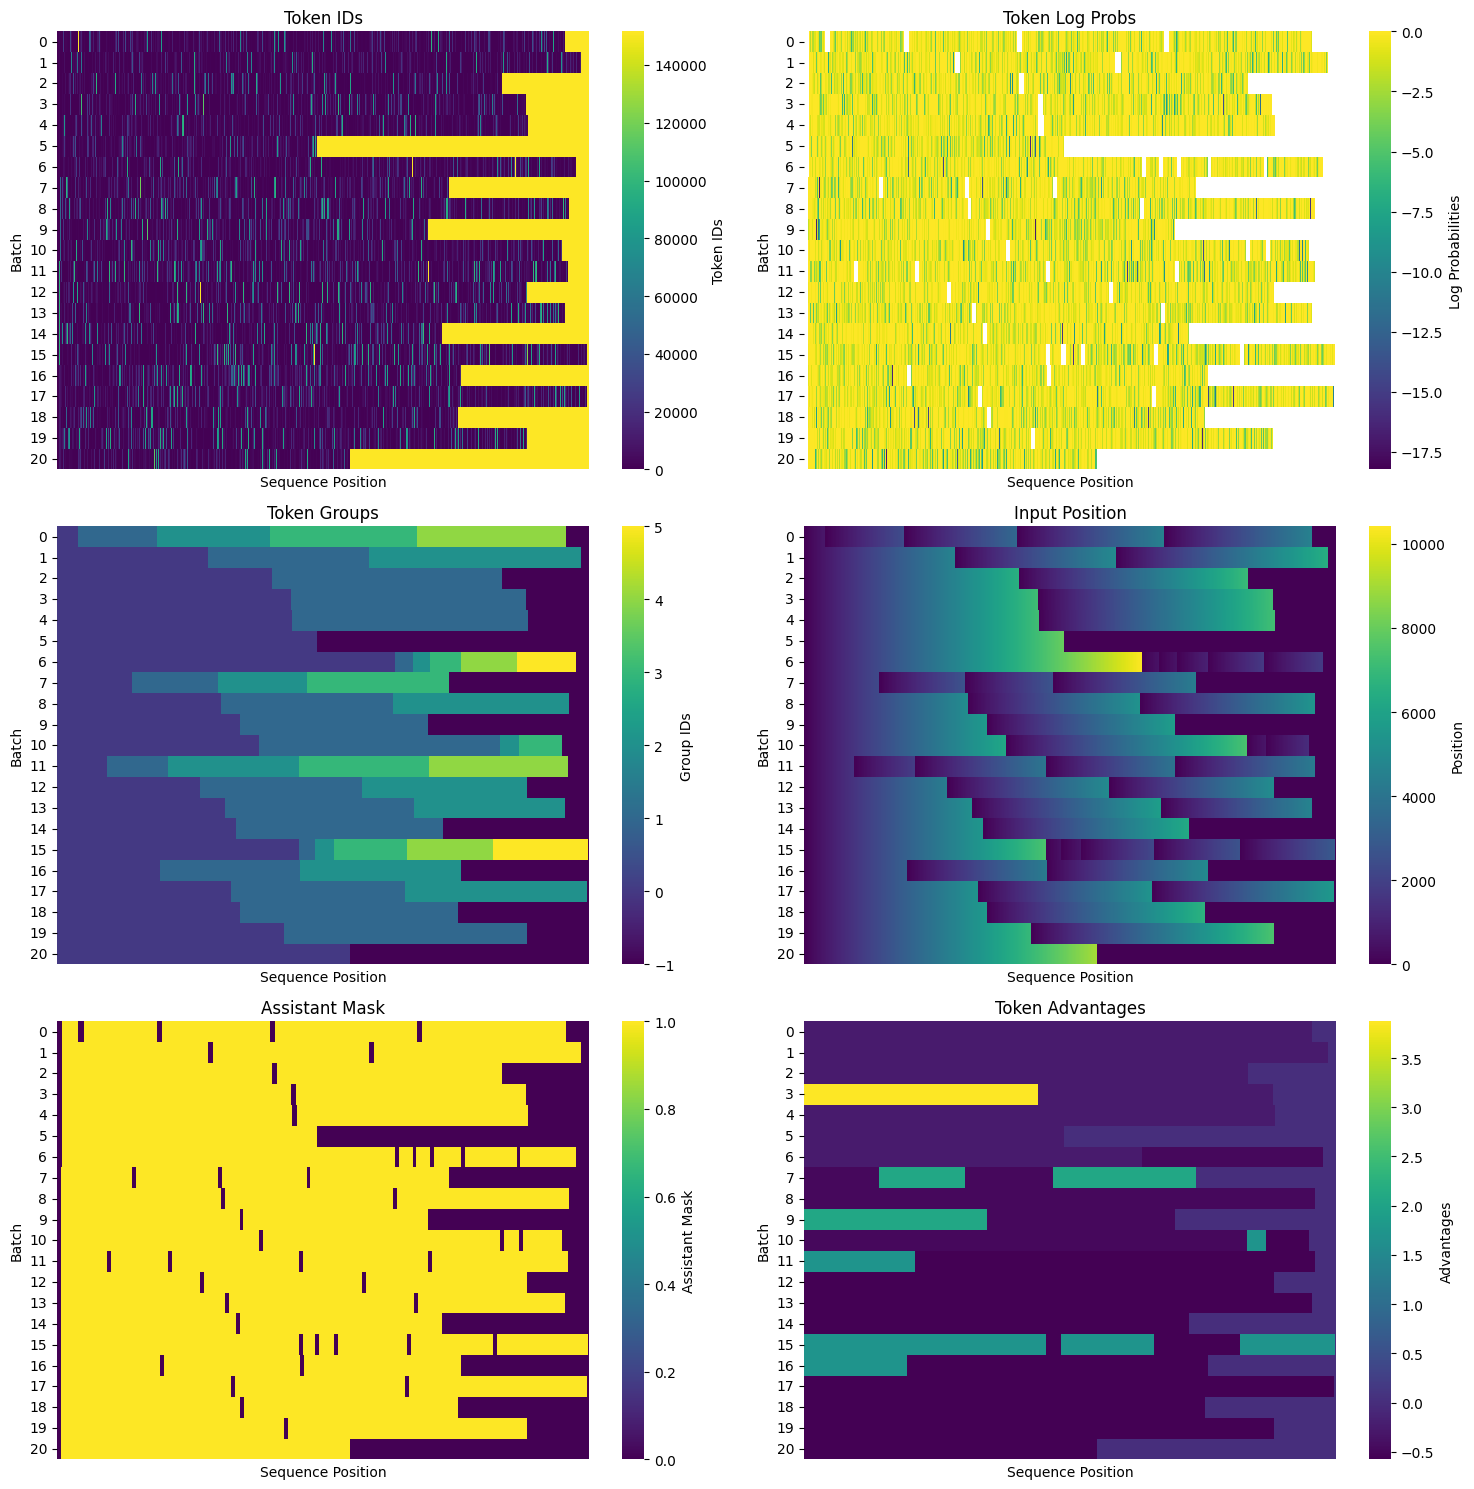

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/011/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/011
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/011/tensors
  num_seque

Writing logs to models/011/logs/log_1739980452.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 29.97 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|10|Loss: 0.5630: 100%|██████████| 10/10 [04:49<00:00, 28.04s/it, entropy=2.62, kl_div=0.527, loss=0.563, policy=0.563] INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.61 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved t

Saved iteration 1 model files to ./models/011/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/011/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/011/0001 --port=8000 --api-key=default
INFO 02-19 16:00:12 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 16:00:13 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 16:00:13 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/011/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:06<00:06,  6.82s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:10<00:00,  5.19s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:10<00:00,  5.43s/it]



INFO 02-19 16:00:41 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 16:00:42 worker.py:267] Memory profiling takes 0.88 seconds
INFO 02-19 16:00:42 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 16:00:42 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 16:00:42 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 16:00:42 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 16:01:22 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.77 seconds
INFO 02-19 16:01:23 api_server.py:756] Using supplied chat template:
INFO 02-19 16:01:23 api_server.py:756] None
INFO 02-19 16:01:23 launcher.py:21] Available routes are:
INFO 02-19 16:01:23 launcher.py:29] Route: /

INFO:     Started server process [12131]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 16:01:29 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-19 16:01:29 metrics.py:455] Avg prompt throughput: 0.9 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-19 16:01:29 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:53678 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a420fdee980>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/256 [00:00<?, ?it/s]

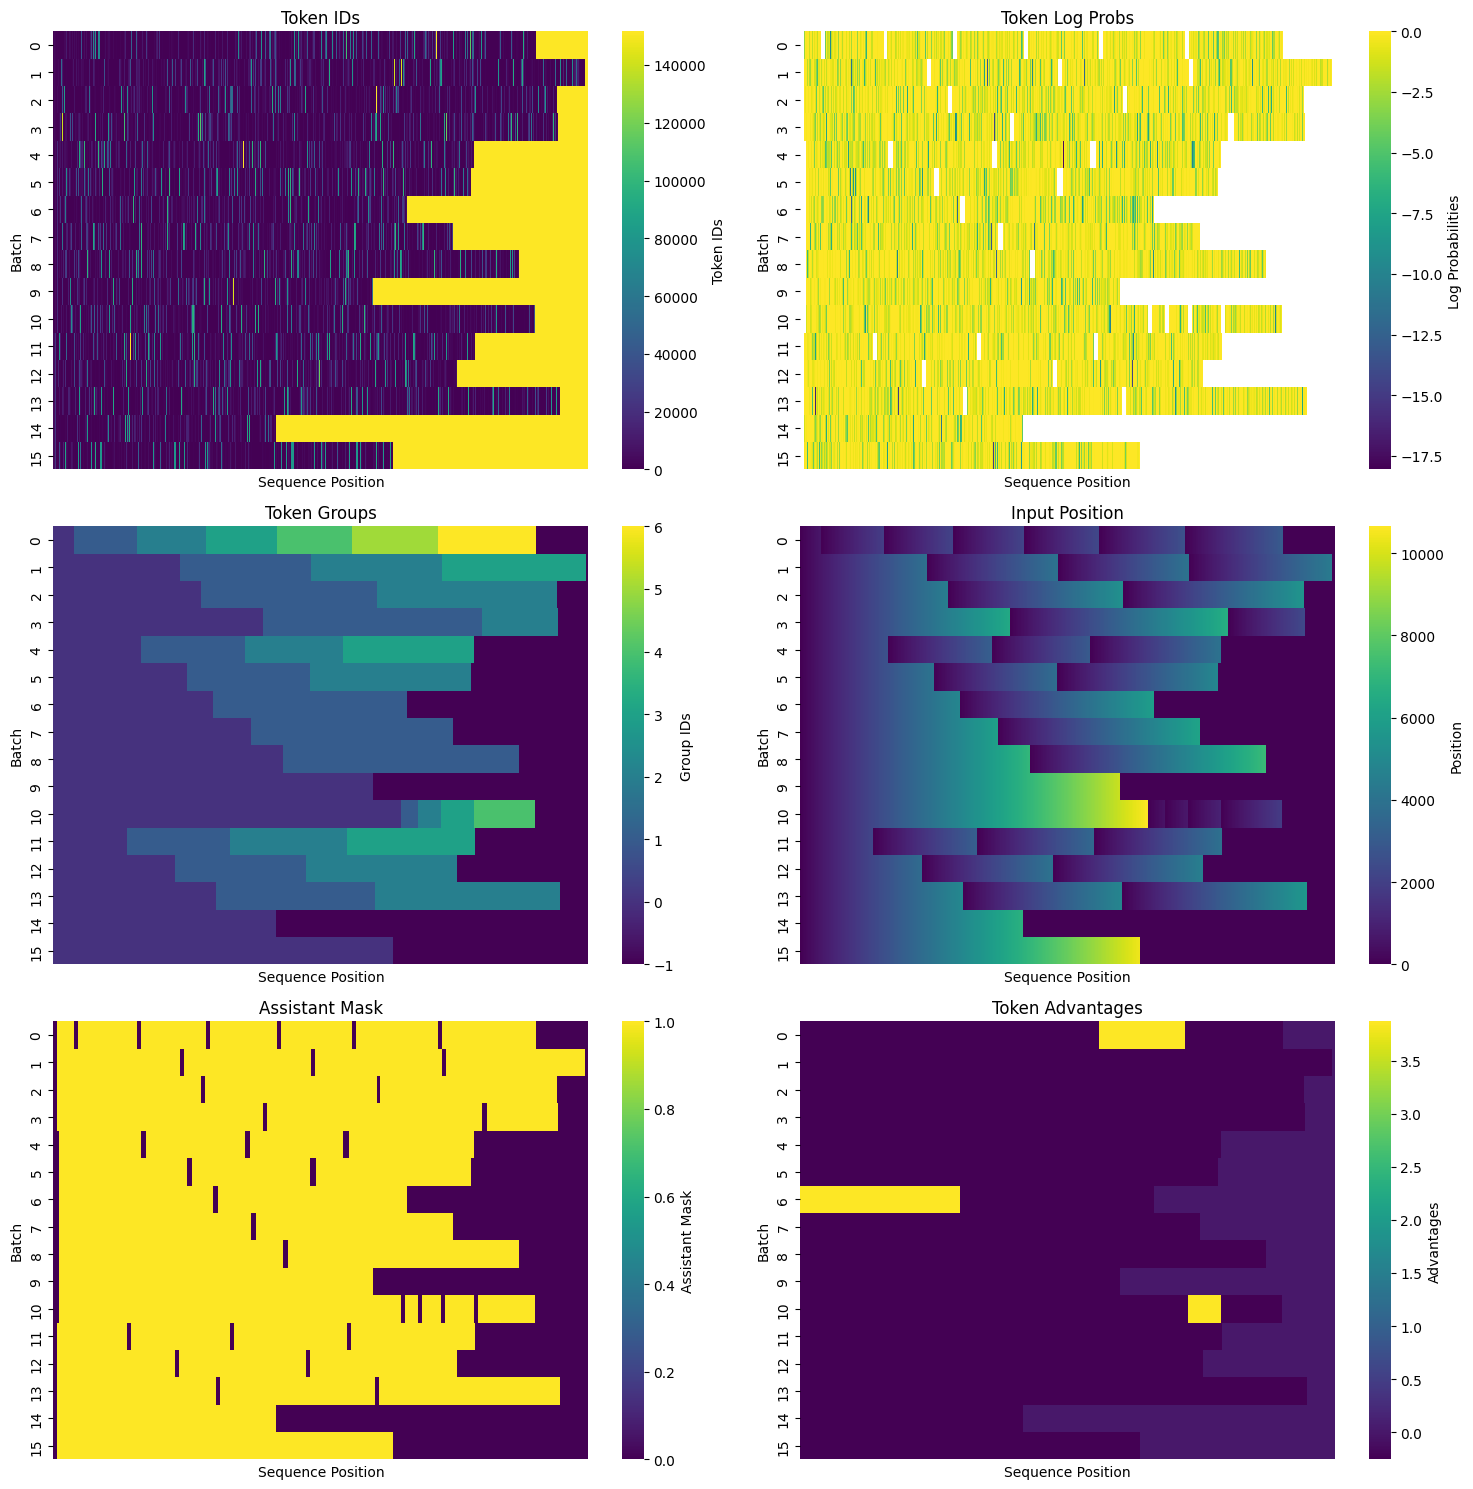

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/011/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/011
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/011/tensors
  num_seque

Writing logs to models/011/logs/log_1739981321.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 30.61 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|8|Loss: 0.2017: 100%|██████████| 8/8 [03:53<00:00, 28.04s/it, entropy=2.86, kl_div=0.522, loss=0.202, policy=0.202]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.54 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved t

Saved iteration 1 model files to ./models/011/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/011/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/011/0001 --port=8000 --api-key=default
INFO 02-19 16:13:45 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 16:13:46 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 16:13:46 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/011/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:08<00:08,  8.12s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:12<00:00,  5.68s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:12<00:00,  6.04s/it]



INFO 02-19 16:14:15 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 16:14:15 worker.py:267] Memory profiling takes 0.87 seconds
INFO 02-19 16:14:15 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 16:14:15 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 16:14:16 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 16:14:16 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 16:14:56 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 41.06 seconds
INFO 02-19 16:14:57 api_server.py:756] Using supplied chat template:
INFO 02-19 16:14:57 api_server.py:756] None
INFO 02-19 16:14:57 launcher.py:21] Available routes are:
INFO 02-19 16:14:57 launcher.py:29] Route: /

INFO:     Started server process [13194]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 16:15:04 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-19 16:15:04 metrics.py:455] Avg prompt throughput: 0.9 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-19 16:15:04 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:36644 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a420fdee980>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/256 [00:00<?, ?it/s]

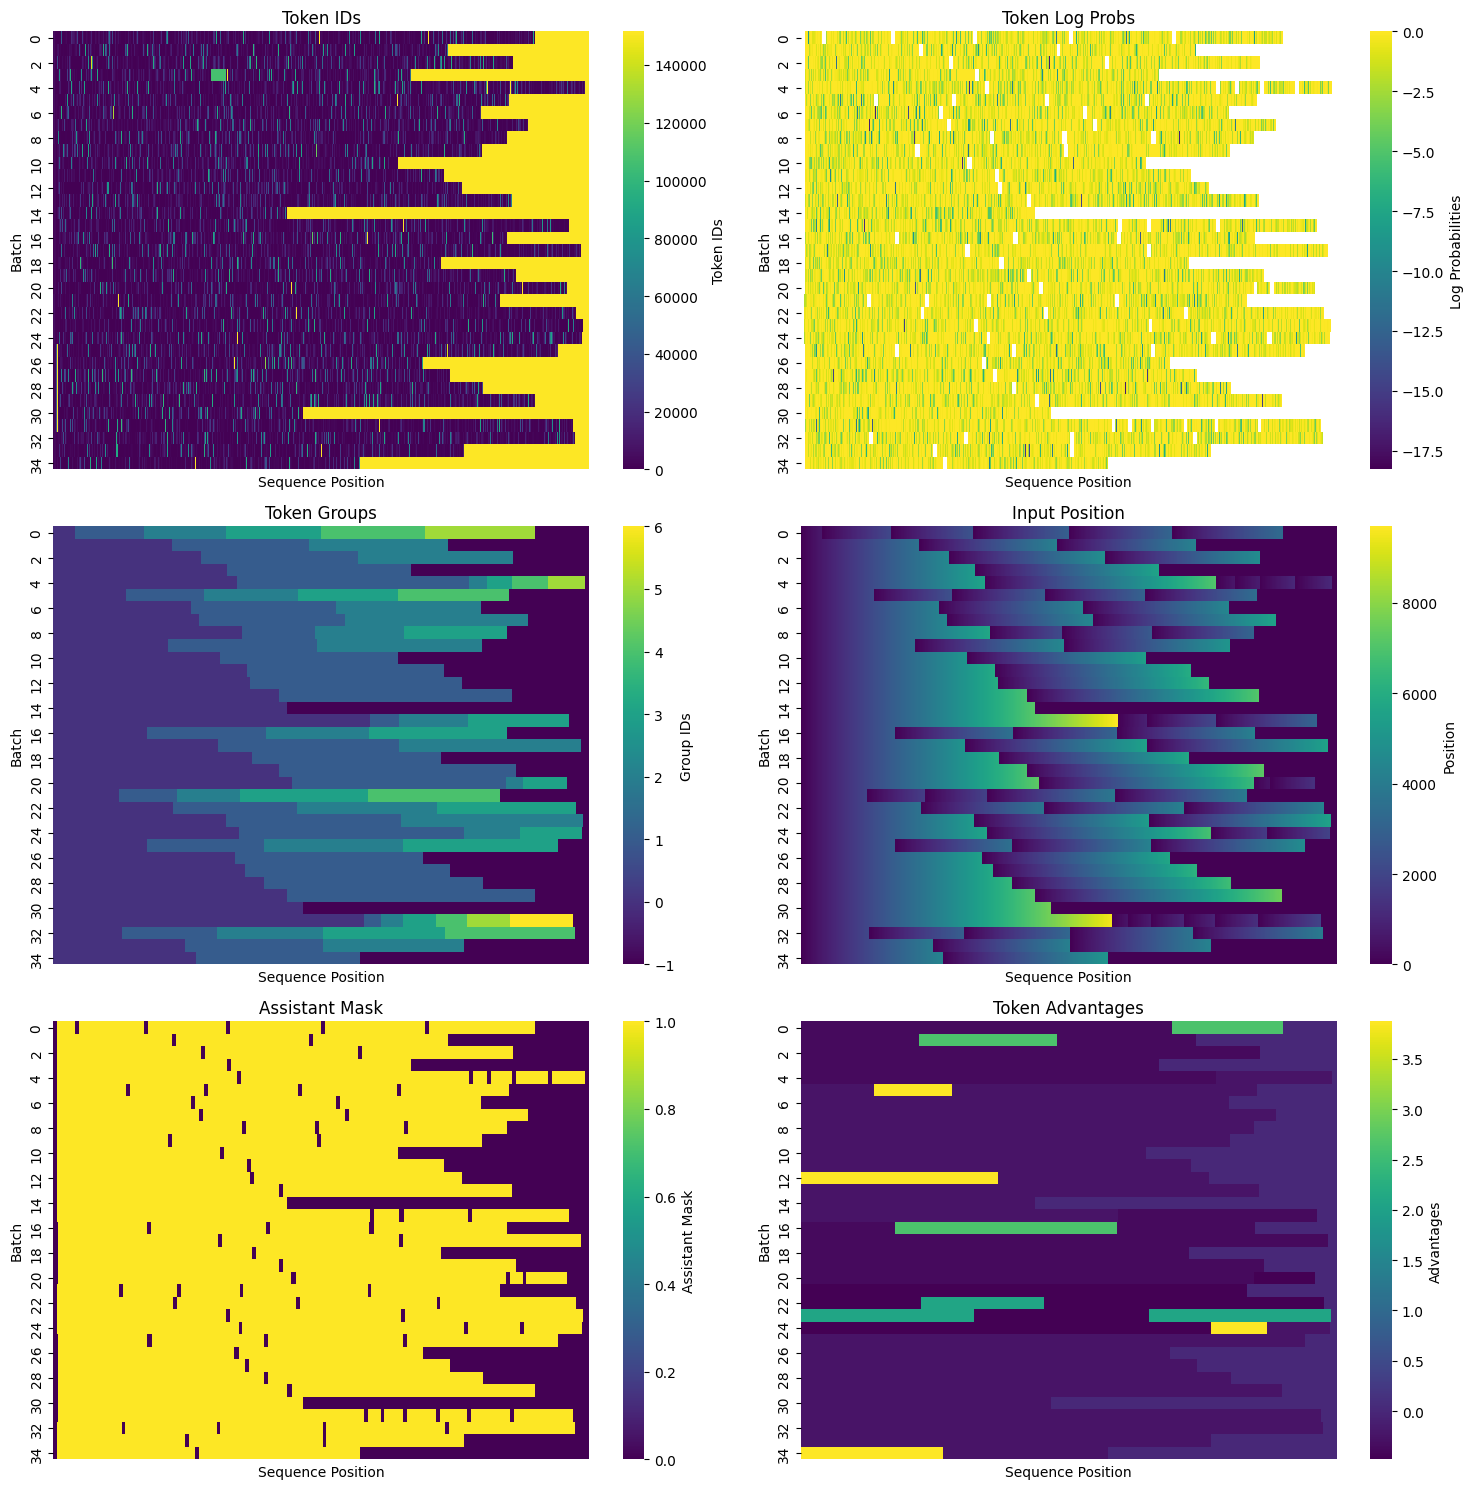

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/011/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/011
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/011/tensors
  num_seque

Writing logs to models/011/logs/log_1739982137.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.32 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|17|Loss: 0.2265: 100%|██████████| 17/17 [08:04<00:00, 27.87s/it, entropy=1.92, kl_div=0.459, loss=0.226, policy=0.226]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.41 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved 

Saved iteration 1 model files to ./models/011/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/011/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/011/0001 --port=8000 --api-key=default
INFO 02-19 16:31:32 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 16:31:33 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 16:31:33 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/011/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.69s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.69s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.84s/it]



INFO 02-19 16:31:59 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 16:32:00 worker.py:267] Memory profiling takes 0.81 seconds
INFO 02-19 16:32:00 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 16:32:00 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 16:32:00 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 16:32:00 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 16:32:40 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.94 seconds
INFO 02-19 16:32:41 api_server.py:756] Using supplied chat template:
INFO 02-19 16:32:41 api_server.py:756] None
INFO 02-19 16:32:41 launcher.py:21] Available routes are:
INFO 02-19 16:32:41 launcher.py:29] Route: /

INFO:     Started server process [13929]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 16:32:43 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:48842 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a420fdee980>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/256 [00:00<?, ?it/s]

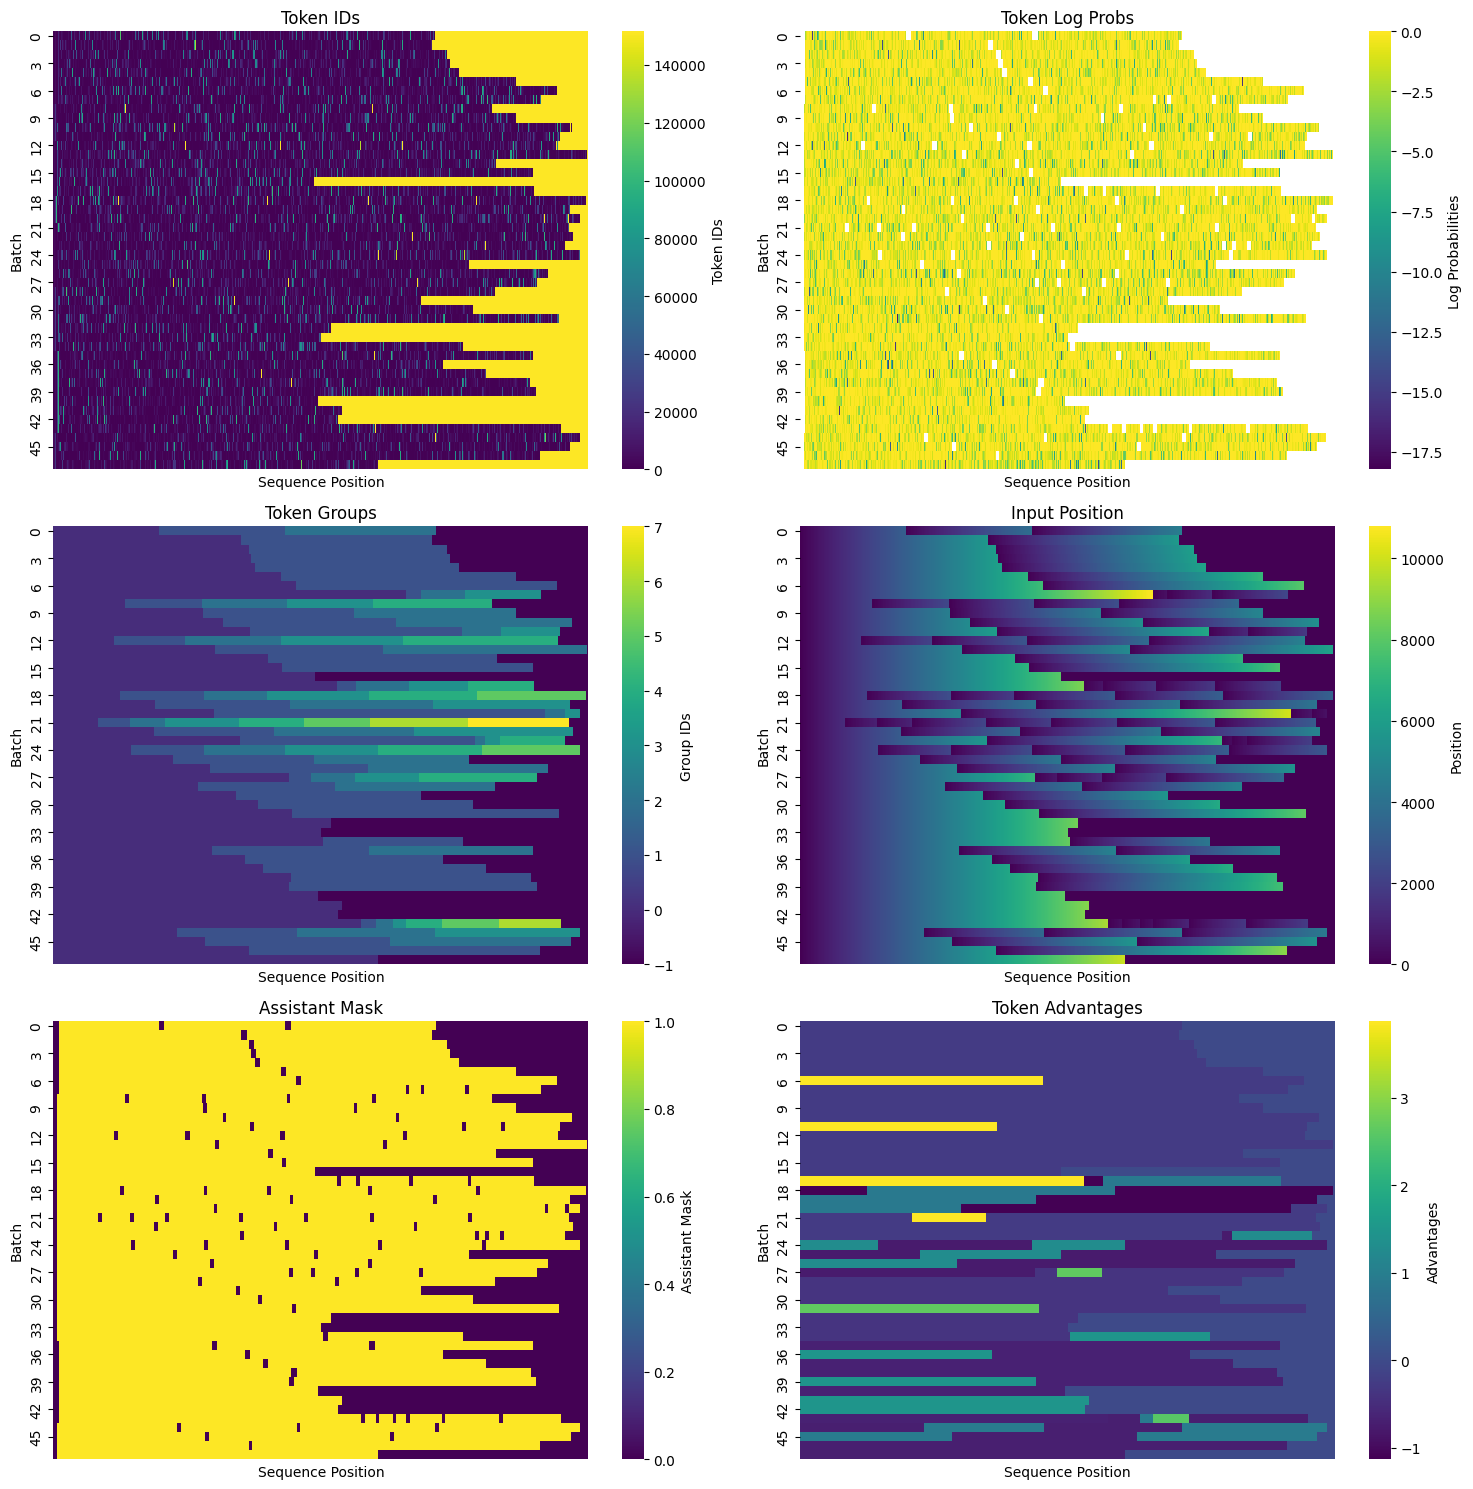

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/011/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/011
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/011/tensors
  num_seque

Writing logs to models/011/logs/log_1739983218.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 30.63 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|24|Loss: 2.2892: 100%|██████████| 24/24 [11:19<00:00, 27.87s/it, entropy=2.94, kl_div=0.567, loss=2.29, policy=2.29]       INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.38 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB save

Saved iteration 1 model files to ./models/011/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/011/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/011/0001 --port=8000 --api-key=default
INFO 02-19 16:52:47 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 16:52:48 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 16:52:48 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/011/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, 

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:06<00:06,  6.32s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:10<00:00,  5.00s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:10<00:00,  5.20s/it]



INFO 02-19 16:53:12 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 16:53:13 worker.py:267] Memory profiling takes 0.80 seconds
INFO 02-19 16:53:13 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 16:53:13 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 16:53:13 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 16:53:13 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 16:53:50 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 37.94 seconds
INFO 02-19 16:53:51 api_server.py:756] Using supplied chat template:
INFO 02-19 16:53:51 api_server.py:756] None
INFO 02-19 16:53:51 launcher.py:21] Available routes are:
INFO 02-19 16:53:51 launcher.py:29] Route: /

INFO:     Started server process [14612]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 16:53:52 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:35754 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7a420fdee980>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/256 [00:00<?, ?it/s]

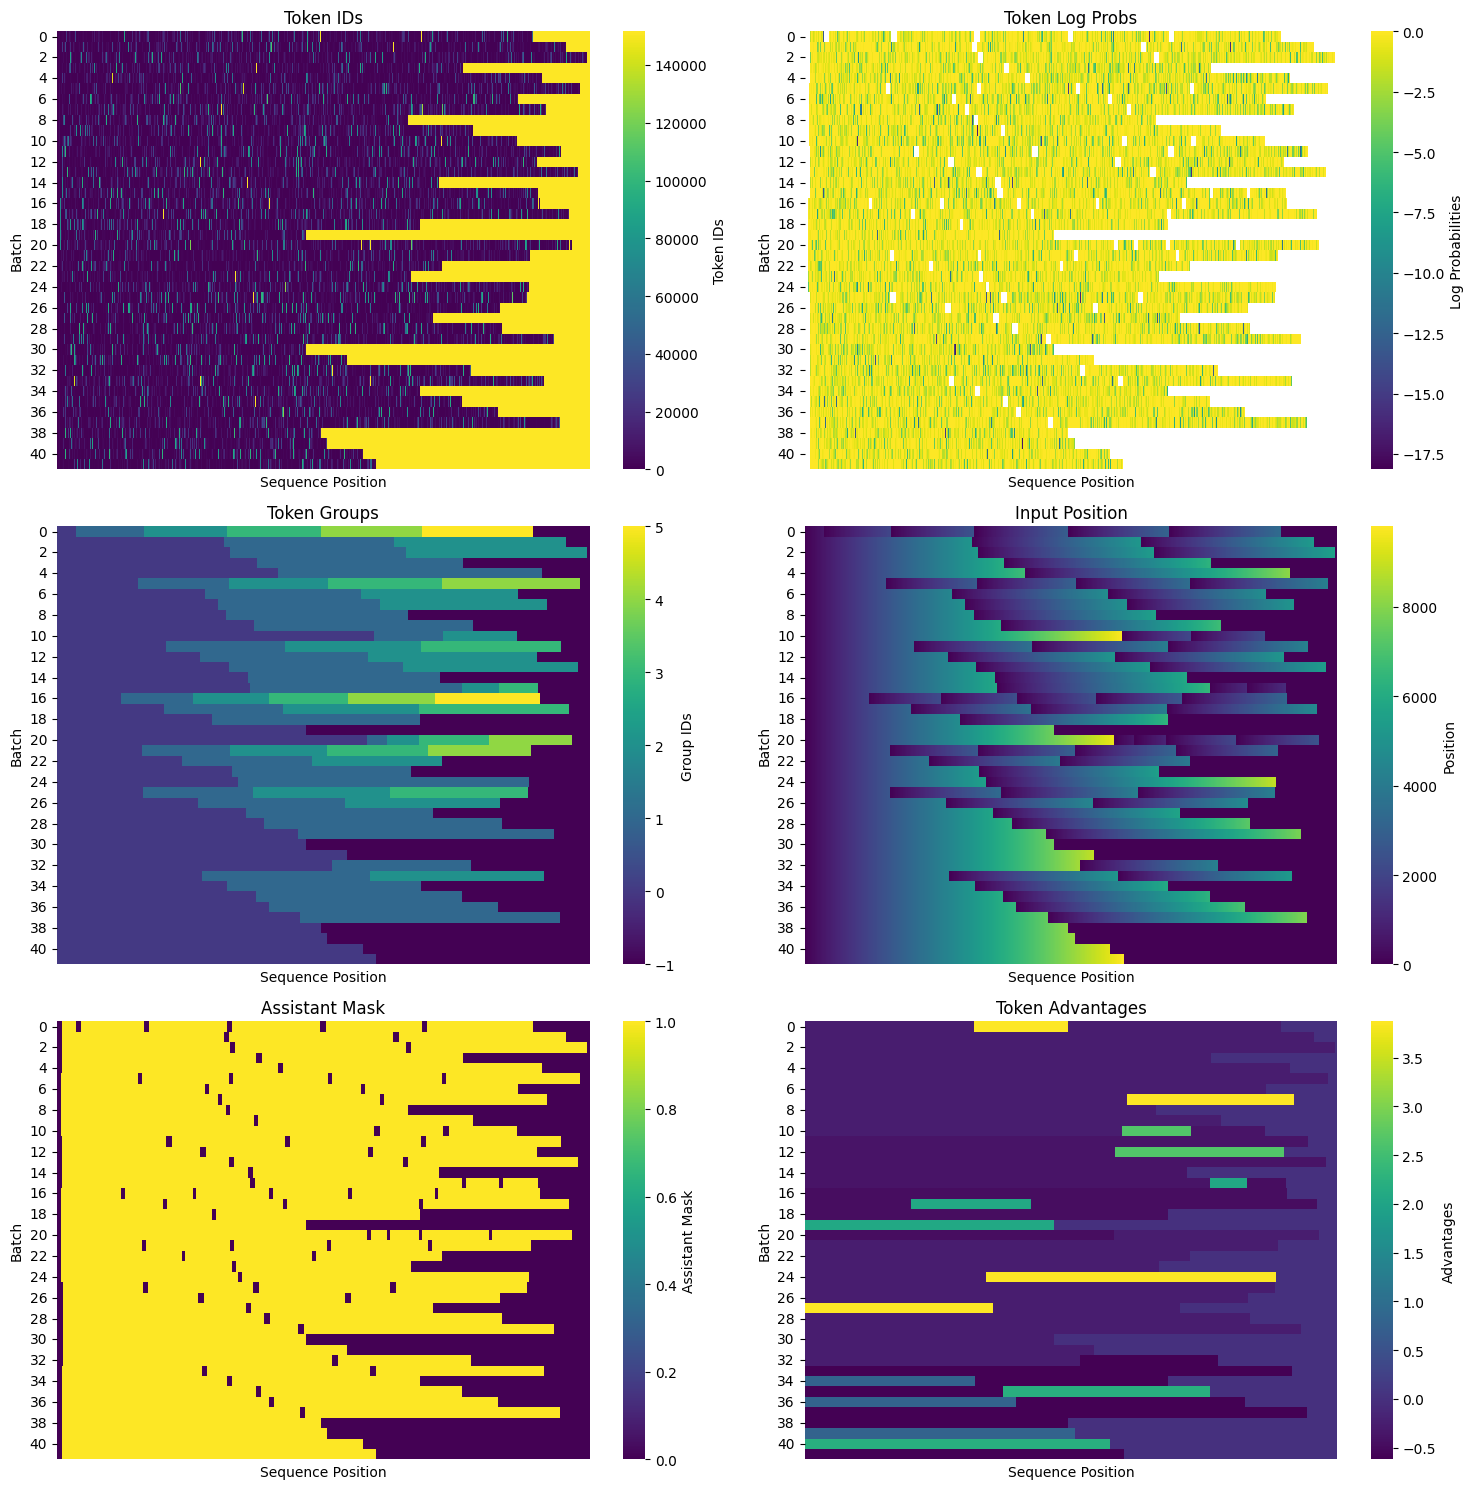

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/011/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/011
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/011/tensors
  num_seque

Writing logs to models/011/logs/log_1739984463.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 30.30 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|21|Loss: -0.6722: 100%|██████████| 21/21 [09:55<00:00, 27.73s/it, entropy=2.73, kl_div=0.498, loss=-0.672, policy=-0.672]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.50 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved 

Saved iteration 1 model files to ./models/011/0001


entropy,█▃█▁▂▅▅▁▄
exceptions,▁▁▁▁▁▁▁▁▁▁
iteration,▁▂▃▃▄▅▆▆▇█
kl_div,█▁▆▃▃▅▄▄▃
loss,▇▇▇▁▇████
policy,▇▇▇▁▇████
reward,█▁█▁▁▁▄▁▁▁
tokens,▆▁▄▄▃████▅
tokens_per_second_per_gpu,▁▅▅▇▇█▃▇▇
entropy,2.32194
exceptions,0


In [4]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = float("inf")
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0

expected_tokens = 3500  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 1e-5
model = models.qwen_7b()
wandb.config["model"] = model_name = model.base_model
num_iterations = 10
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 16
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 16
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity = 2

for i in range(get_iteration(output_dir), num_iterations + 1):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=512,
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=512,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=120 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(vllm.max_concurrent_tokens // expected_tokens)
    offset = i * stride
    (_, val_stats), (train_results, train_stats) = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": val_stats.completion_tokens / val_stats.usages,
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = round(wandb_data["tokens"])
    vllm.process.terminate()
    kill_vllm_workers()
    packed_tensors = packed_tensors_from_tokenized_results(
        [
            result
            for results in train_results
            for result in results
            if result.advantage != 0
        ],
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(model.tune_optimizer, lr=lr)
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
            ),
            optimizer=optimizer_config,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=8,
        ),
        verbosity=verbosity,
    )
wandb.finish()